C:\Users\xiao\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\xiao\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


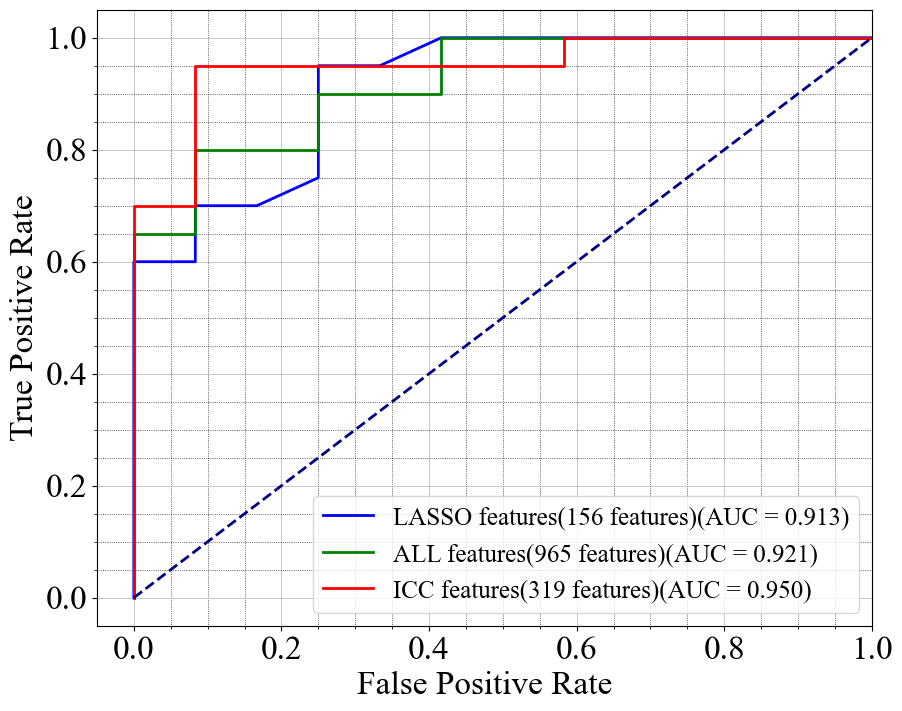

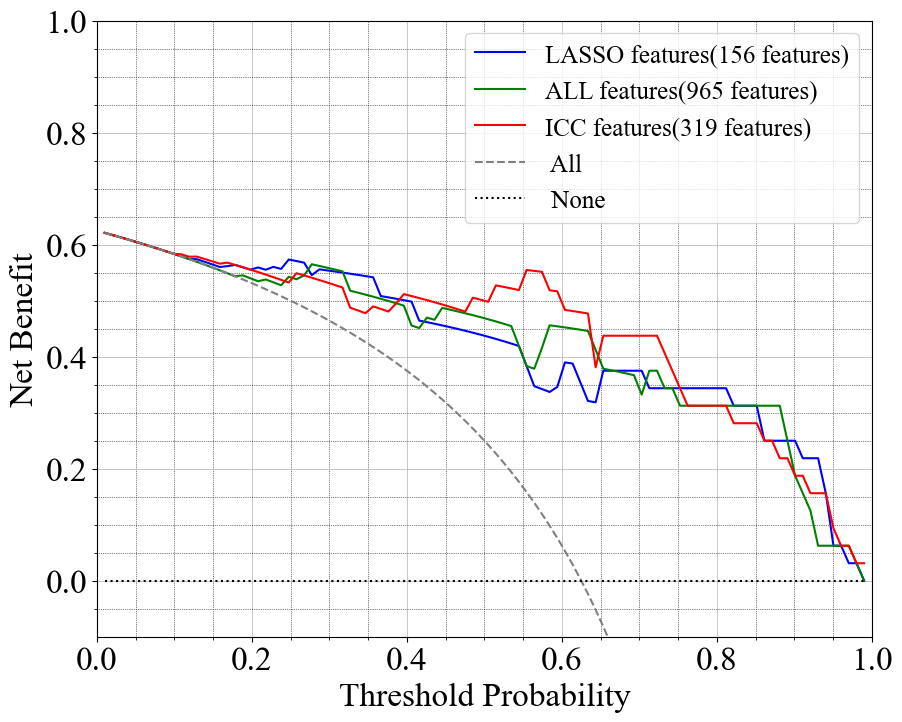

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import numpy as np

# Function to calculate net benefit for the model
def calculate_net_benefit(thresholds, y_true, y_proba):
    net_benefits = []
    for threshold in thresholds:
        w = threshold / (1 - threshold)  # Weight for false positives
        predictions = y_proba >= threshold  # Predictions based on the current threshold
        tp = np.sum((predictions == 1) & (y_true == 1))  # True positives
        fp = np.sum((predictions == 1) & (y_true == 0))  # False positives
        net_benefit = tp - (fp * w)  # Calculate net benefit
        net_benefits.append(net_benefit / len(y_true))
    return net_benefits

# Calculate net benefit for "All" treated (assumes all cases are positive)
def net_benefit_all(thresholds, y_true):
    prevalence = np.mean(y_true)
    return [prevalence - (1 - prevalence) * (threshold / (1 - threshold)) for threshold in thresholds]

# Calculate net benefit for "None" treated (assumes no cases are positive)
def net_benefit_none(thresholds):
    return [0 for _ in thresholds]

# Decision Curve Analysis
def decision_curve_analysis(y_true, y_pred_proba, thresholds):
    num_cases = len(y_true)
    net_benefits = []
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        net_benefit = calculate_net_benefit(tp, fp, threshold, num_cases)
        net_benefits.append(net_benefit)
    return net_benefits

# Read datasets
train_data1 = pd.read_csv('D:/radiomic1/glioma/csv4/lasso_selected_features_train_t2_s1.csv')
test_data1 = pd.read_csv('D:/radiomic1/glioma/csv4/lasso_selected_features_test_t2_s1.csv')
train_data2 = pd.read_csv('D:/radiomic1/glioma/csv4/train_t2_s1.csv')
test_data2 = pd.read_csv('D:/radiomic1/glioma/csv4/test_t2_s1.csv')
train_data3 = pd.read_csv('D:/radiomic1/glioma/csv4/train_t2_s1_icc_selection.csv')
test_data3 = pd.read_csv('D:/radiomic1/glioma/csv4/test_t2_s1_icc_selection.csv')

# Prepare data for both models
X_train1 = train_data1.drop('label', axis=1)
y_train1 = train_data1['label']
X_test1 = test_data1.drop('label', axis=1)
y_test1 = test_data1['label']

X_train2 = train_data2.iloc[:, 2:] 
y_train2 = train_data2['label']
X_test2 = test_data2.iloc[:, 2:] 
y_test2 = test_data2['label']

X_train3 = train_data3.drop('label', axis=1)
y_train3 = train_data3['label']
X_test3 = test_data3.drop('label', axis=1)
y_test3 = test_data3['label']

# Initialize and train random forest models
model1 = RandomForestClassifier(n_estimators=300, random_state=42)
model1.fit(X_train1, y_train1)
y_pred_proba1 = model1.predict_proba(X_test1)[:, 1]

model2 = RandomForestClassifier(n_estimators=300, random_state=42)
model2.fit(X_train2, y_train2)
y_pred_proba2 = model2.predict_proba(X_test2)[:, 1]

model3 = RandomForestClassifier(n_estimators=300, random_state=42)
model3.fit(X_train3, y_train3)
y_pred_proba3 = model3.predict_proba(X_test3)[:, 1]

# 计算AUC
auc_score1 = roc_auc_score(y_test1, y_pred_proba1)
auc_score2 = roc_auc_score(y_test2, y_pred_proba2)
auc_score3 = roc_auc_score(y_test3, y_pred_proba3)

# Range of thresholds from 0.01 to 0.99
thresholds = np.linspace(0.01, 0.99, 100)

# Calculate net benefits for both models
model1_net_benefits = calculate_net_benefit(thresholds, y_test1, y_pred_proba1)
all_net_benefits1 = net_benefit_all(thresholds, y_test1)
none_net_benefits1 = net_benefit_none(thresholds)

model2_net_benefits = calculate_net_benefit(thresholds, y_test2, y_pred_proba2)
all_net_benefits2 = net_benefit_all(thresholds, y_test2)
none_net_benefits2 = net_benefit_none(thresholds)

model3_net_benefits = calculate_net_benefit(thresholds, y_test3, y_pred_proba3)
all_net_benefits3 = net_benefit_all(thresholds, y_test3)
none_net_benefits3 = net_benefit_none(thresholds)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
plt.rcParams['font.family'] = 'Times New Roman'
# Assuming you have these variables defined: y_test1, y_pred_proba1, auc_score1, etc.

plt.figure(figsize=(10, 8))

# ROC Curve for Model 1
fpr1, tpr1, _ = roc_curve(y_test1, y_pred_proba1)
plt.plot(fpr1, tpr1, color='blue', lw=2, label='LASSO features(156 features)(AUC = %0.3f)' % auc_score1)

# ROC Curve for Model 2
fpr2, tpr2, _ = roc_curve(y_test2, y_pred_proba2)
plt.plot(fpr2, tpr2, color='green', lw=2, label='ALL features(965 features)(AUC = %0.3f)' % auc_score2)

fpr3, tpr3, _ = roc_curve(y_test3, y_pred_proba3)
plt.plot(fpr3, tpr3, color='red', lw=2, label='ICC features(319 features)(AUC = %0.3f)' % auc_score3)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc="lower right", fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black') 
plt.show()

plt.figure(figsize=(10, 8))
# DCA for Model 1
plt.plot(thresholds, model1_net_benefits, label='LASSO features(156 features)', color='blue', linestyle='-')

# DCA for Model 2
plt.plot(thresholds, model2_net_benefits, label='ALL features(965 features)', color='green', linestyle='-')
# DCA for Model 3
plt.plot(thresholds, model3_net_benefits, label='ICC features(319 features)', color='red', linestyle='-')
plt.plot(thresholds, all_net_benefits1, label=' All', color='gray', linestyle='--')
plt.plot(thresholds, none_net_benefits1, label=' None', color='black', linestyle=':')
plt.xlabel('Threshold Probability', fontsize=24)
plt.ylabel('Net Benefit', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper right', fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black') 
plt.xlim([0, 1])
plt.ylim([-0.1, 1])
plt.show()

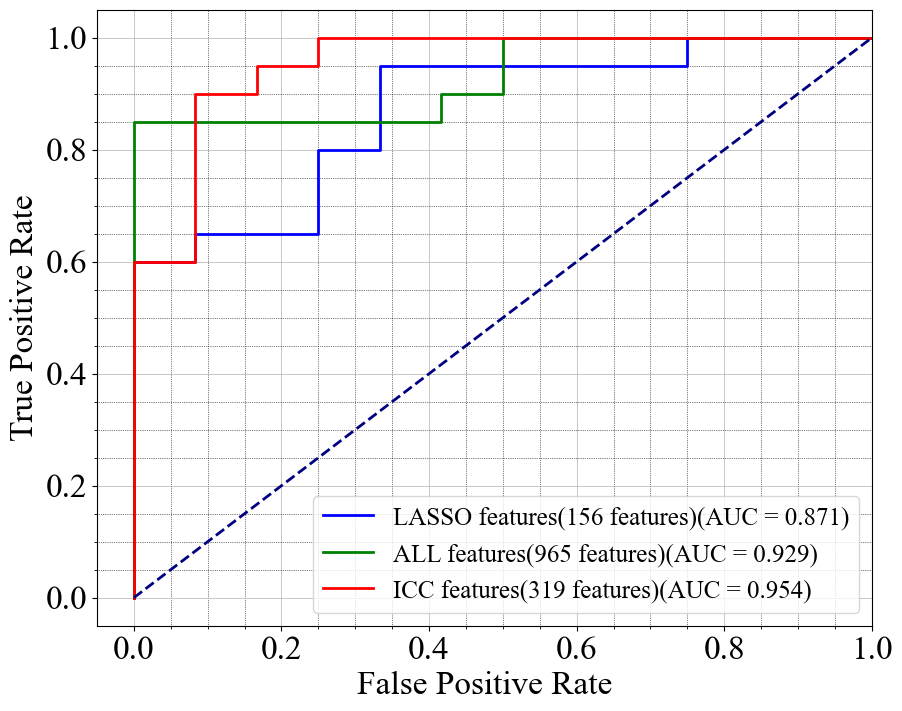

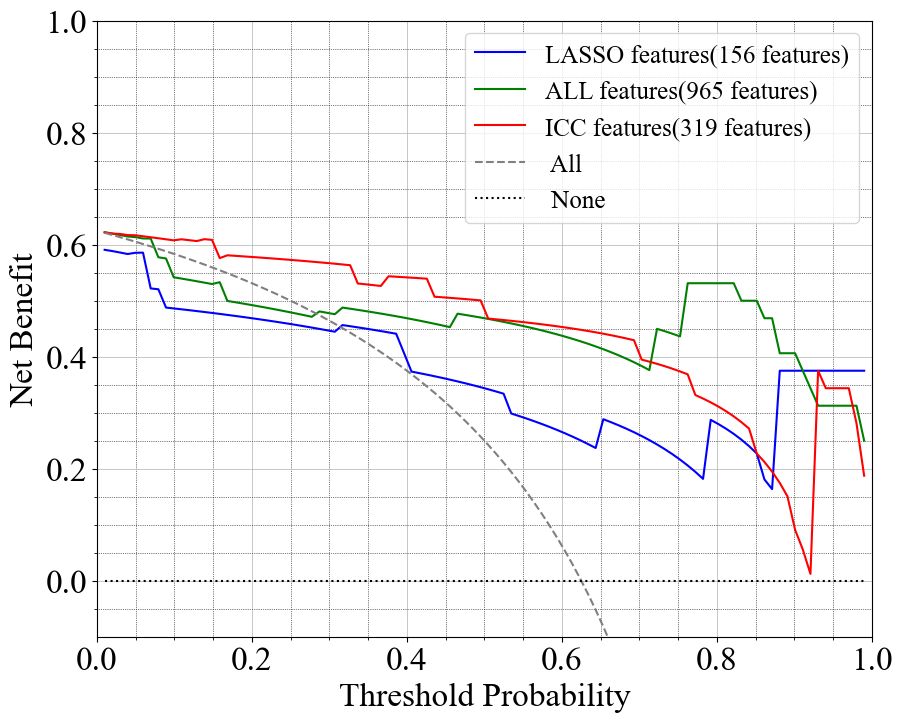

In [2]:
#xgboost
import pandas as pd
from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import numpy as np

# Function to calculate net benefit for the model
def calculate_net_benefit(thresholds, y_true, y_proba):
    net_benefits = []
    for threshold in thresholds:
        w = threshold / (1 - threshold)  # Weight for false positives
        predictions = y_proba >= threshold  # Predictions based on the current threshold
        tp = np.sum((predictions == 1) & (y_true == 1))  # True positives
        fp = np.sum((predictions == 1) & (y_true == 0))  # False positives
        net_benefit = tp - (fp * w)  # Calculate net benefit
        net_benefits.append(net_benefit / len(y_true))
    return net_benefits

# Calculate net benefit for "All" treated (assumes all cases are positive)
def net_benefit_all(thresholds, y_true):
    prevalence = np.mean(y_true)
    return [prevalence - (1 - prevalence) * (threshold / (1 - threshold)) for threshold in thresholds]

# Calculate net benefit for "None" treated (assumes no cases are positive)
def net_benefit_none(thresholds):
    return [0 for _ in thresholds]

# Decision Curve Analysis
def decision_curve_analysis(y_true, y_pred_proba, thresholds):
    num_cases = len(y_true)
    net_benefits = []
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        net_benefit = calculate_net_benefit(tp, fp, threshold, num_cases)
        net_benefits.append(net_benefit)
    return net_benefits

# Read datasets
train_data1 = pd.read_csv('D:/radiomic1/glioma/csv4/lasso_selected_features_train_t2_s1.csv')
test_data1 = pd.read_csv('D:/radiomic1/glioma/csv4/lasso_selected_features_test_t2_s1.csv')
train_data2 = pd.read_csv('D:/radiomic1/glioma/csv4/train_t2_s1.csv')
test_data2 = pd.read_csv('D:/radiomic1/glioma/csv4/test_t2_s1.csv')
train_data3 = pd.read_csv('D:/radiomic1/glioma/csv4/train_t2_s1_icc_selection.csv')
test_data3 = pd.read_csv('D:/radiomic1/glioma/csv4/test_t2_s1_icc_selection.csv')

# Prepare data for both models
X_train1 = train_data1.drop('label', axis=1)
y_train1 = train_data1['label']
X_test1 = test_data1.drop('label', axis=1)
y_test1 = test_data1['label']

X_train2 = train_data2.iloc[:, 2:] 
y_train2 = train_data2['label']
X_test2 = test_data2.iloc[:, 2:] 
y_test2 = test_data2['label']

X_train3 = train_data3.drop('label', axis=1)
y_train3 = train_data3['label']
X_test3 = test_data3.drop('label', axis=1)
y_test3 = test_data3['label']

# Initialize and train random forest models
model1 = XGBClassifier(use_label_encoder=False)
model1.fit(X_train1, y_train1)
y_pred_proba1 = model1.predict_proba(X_test1)[:, 1]

model2 = XGBClassifier(use_label_encoder=False)
model2.fit(X_train2, y_train2)
y_pred_proba2 = model2.predict_proba(X_test2)[:, 1]

model3 = XGBClassifier(use_label_encoder=False)
model3.fit(X_train3, y_train3)
y_pred_proba3 = model3.predict_proba(X_test3)[:, 1]

# 计算AUC
auc_score1 = roc_auc_score(y_test1, y_pred_proba1)
auc_score2 = roc_auc_score(y_test2, y_pred_proba2)
auc_score3 = roc_auc_score(y_test3, y_pred_proba3)

# Range of thresholds from 0.01 to 0.99
thresholds = np.linspace(0.01, 0.99, 100)

# Calculate net benefits for both models
model1_net_benefits = calculate_net_benefit(thresholds, y_test1, y_pred_proba1)
all_net_benefits1 = net_benefit_all(thresholds, y_test1)
none_net_benefits1 = net_benefit_none(thresholds)

model2_net_benefits = calculate_net_benefit(thresholds, y_test2, y_pred_proba2)
all_net_benefits2 = net_benefit_all(thresholds, y_test2)
none_net_benefits2 = net_benefit_none(thresholds)

model3_net_benefits = calculate_net_benefit(thresholds, y_test3, y_pred_proba3)
all_net_benefits3 = net_benefit_all(thresholds, y_test3)
none_net_benefits3 = net_benefit_none(thresholds)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
plt.rcParams['font.family'] = 'Times New Roman'
# Assuming you have these variables defined: y_test1, y_pred_proba1, auc_score1, etc.

plt.figure(figsize=(10, 8))

# ROC Curve for Model 1
fpr1, tpr1, _ = roc_curve(y_test1, y_pred_proba1)
plt.plot(fpr1, tpr1, color='blue', lw=2, label='LASSO features(156 features)(AUC = %0.3f)' % auc_score1)

# ROC Curve for Model 2
fpr2, tpr2, _ = roc_curve(y_test2, y_pred_proba2)
plt.plot(fpr2, tpr2, color='green', lw=2, label='ALL features(965 features)(AUC = %0.3f)' % auc_score2)

fpr3, tpr3, _ = roc_curve(y_test3, y_pred_proba3)
plt.plot(fpr3, tpr3, color='red', lw=2, label='ICC features(319 features)(AUC = %0.3f)' % auc_score3)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc="lower right", fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black') 
plt.show()

plt.figure(figsize=(10, 8))
# DCA for Model 1
plt.plot(thresholds, model1_net_benefits, label='LASSO features(156 features)', color='blue', linestyle='-')

# DCA for Model 2
plt.plot(thresholds, model2_net_benefits, label='ALL features(965 features)', color='green', linestyle='-')
# DCA for Model 3
plt.plot(thresholds, model3_net_benefits, label='ICC features(319 features)', color='red', linestyle='-')
plt.plot(thresholds, all_net_benefits1, label=' All', color='gray', linestyle='--')
plt.plot(thresholds, none_net_benefits1, label=' None', color='black', linestyle=':')
plt.xlabel('Threshold Probability', fontsize=24)
plt.ylabel('Net Benefit', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper right', fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black') 
plt.xlim([0, 1])
plt.ylim([-0.1, 1])
plt.show()


C:\Users\xiao\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\xiao\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


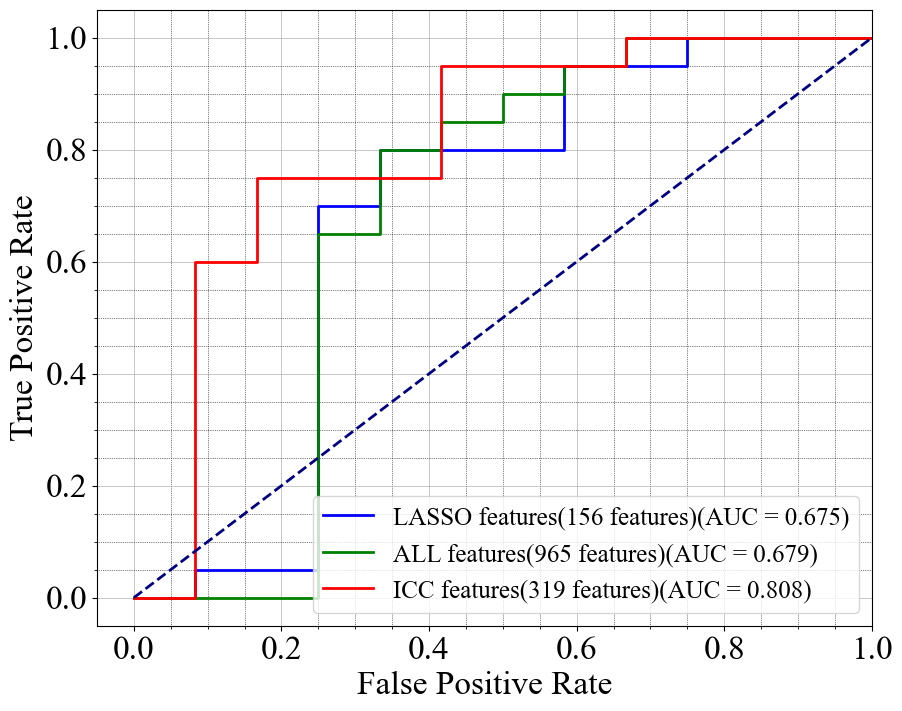

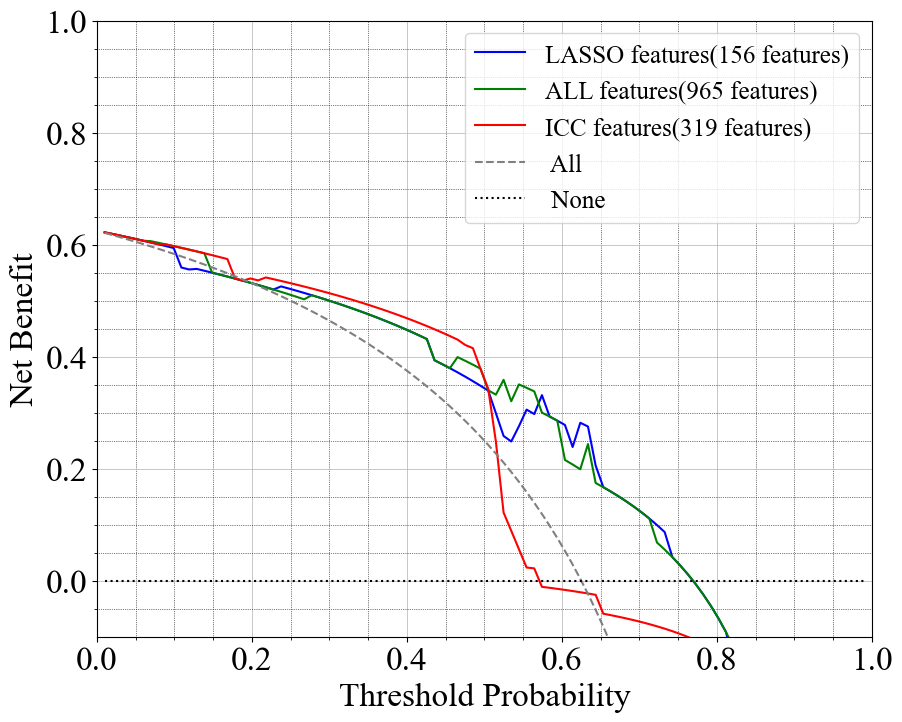

In [3]:
#LR
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import numpy as np

# Function to calculate net benefit for the model
def calculate_net_benefit(thresholds, y_true, y_proba):
    net_benefits = []
    for threshold in thresholds:
        w = threshold / (1 - threshold)  # Weight for false positives
        predictions = y_proba >= threshold  # Predictions based on the current threshold
        tp = np.sum((predictions == 1) & (y_true == 1))  # True positives
        fp = np.sum((predictions == 1) & (y_true == 0))  # False positives
        net_benefit = tp - (fp * w)  # Calculate net benefit
        net_benefits.append(net_benefit / len(y_true))
    return net_benefits

# Calculate net benefit for "All" treated (assumes all cases are positive)
def net_benefit_all(thresholds, y_true):
    prevalence = np.mean(y_true)
    return [prevalence - (1 - prevalence) * (threshold / (1 - threshold)) for threshold in thresholds]

# Calculate net benefit for "None" treated (assumes no cases are positive)
def net_benefit_none(thresholds):
    return [0 for _ in thresholds]

# Decision Curve Analysis
def decision_curve_analysis(y_true, y_pred_proba, thresholds):
    num_cases = len(y_true)
    net_benefits = []
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        net_benefit = calculate_net_benefit(tp, fp, threshold, num_cases)
        net_benefits.append(net_benefit)
    return net_benefits

# Read datasets
train_data1 = pd.read_csv('D:/radiomic1/glioma/csv4/lasso_selected_features_train_t2_s1.csv')
test_data1 = pd.read_csv('D:/radiomic1/glioma/csv4/lasso_selected_features_test_t2_s1.csv')
train_data2 = pd.read_csv('D:/radiomic1/glioma/csv4/train_t2_s1.csv')
test_data2 = pd.read_csv('D:/radiomic1/glioma/csv4/test_t2_s1.csv')
train_data3 = pd.read_csv('D:/radiomic1/glioma/csv4/train_t2_s1_icc_selection.csv')
test_data3 = pd.read_csv('D:/radiomic1/glioma/csv4/test_t2_s1_icc_selection.csv')

# Prepare data for both models
X_train1 = train_data1.drop('label', axis=1)
y_train1 = train_data1['label']
X_test1 = test_data1.drop('label', axis=1)
y_test1 = test_data1['label']

X_train2 = train_data2.iloc[:, 2:] 
y_train2 = train_data2['label']
X_test2 = test_data2.iloc[:, 2:] 
y_test2 = test_data2['label']

X_train3 = train_data3.drop('label', axis=1)
y_train3 = train_data3['label']
X_test3 = test_data3.drop('label', axis=1)
y_test3 = test_data3['label']

# Initialize and train random forest models
model1 = LogisticRegression(penalty="l2",solver="liblinear",C=1.0,max_iter=100)
model1.fit(X_train1, y_train1)
y_pred_proba1 = model1.predict_proba(X_test1)[:, 1]

model2 = LogisticRegression(penalty="l2",solver="liblinear",C=1.0,max_iter=100)
model2.fit(X_train2, y_train2)
y_pred_proba2 = model2.predict_proba(X_test2)[:, 1]

model3 =LogisticRegression(penalty="l2",solver="liblinear",C=1.0,max_iter=100)
model3.fit(X_train3, y_train3)
y_pred_proba3 = model3.predict_proba(X_test3)[:, 1]

# 计算AUC
auc_score1 = roc_auc_score(y_test1, y_pred_proba1)
auc_score2 = roc_auc_score(y_test2, y_pred_proba2)
auc_score3 = roc_auc_score(y_test3, y_pred_proba3)

# Range of thresholds from 0.01 to 0.99
thresholds = np.linspace(0.01, 0.99, 100)

# Calculate net benefits for both models
model1_net_benefits = calculate_net_benefit(thresholds, y_test1, y_pred_proba1)
all_net_benefits1 = net_benefit_all(thresholds, y_test1)
none_net_benefits1 = net_benefit_none(thresholds)

model2_net_benefits = calculate_net_benefit(thresholds, y_test2, y_pred_proba2)
all_net_benefits2 = net_benefit_all(thresholds, y_test2)
none_net_benefits2 = net_benefit_none(thresholds)

model3_net_benefits = calculate_net_benefit(thresholds, y_test3, y_pred_proba3)
all_net_benefits3 = net_benefit_all(thresholds, y_test3)
none_net_benefits3 = net_benefit_none(thresholds)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
plt.rcParams['font.family'] = 'Times New Roman'
# Assuming you have these variables defined: y_test1, y_pred_proba1, auc_score1, etc.

plt.figure(figsize=(10, 8))

# ROC Curve for Model 1
fpr1, tpr1, _ = roc_curve(y_test1, y_pred_proba1)
plt.plot(fpr1, tpr1, color='blue', lw=2, label='LASSO features(156 features)(AUC = %0.3f)' % auc_score1)

# ROC Curve for Model 2
fpr2, tpr2, _ = roc_curve(y_test2, y_pred_proba2)
plt.plot(fpr2, tpr2, color='green', lw=2, label='ALL features(965 features)(AUC = %0.3f)' % auc_score2)

fpr3, tpr3, _ = roc_curve(y_test3, y_pred_proba3)
plt.plot(fpr3, tpr3, color='red', lw=2, label='ICC features(319 features)(AUC = %0.3f)' % auc_score3)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc="lower right", fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black') 
plt.show()

plt.figure(figsize=(10, 8))
# DCA for Model 1
plt.plot(thresholds, model1_net_benefits, label='LASSO features(156 features)', color='blue', linestyle='-')

# DCA for Model 2
plt.plot(thresholds, model2_net_benefits, label='ALL features(965 features)', color='green', linestyle='-')
# DCA for Model 3
plt.plot(thresholds, model3_net_benefits, label='ICC features(319 features)', color='red', linestyle='-')
plt.plot(thresholds, all_net_benefits1, label=' All', color='gray', linestyle='--')
plt.plot(thresholds, none_net_benefits1, label=' None', color='black', linestyle=':')
plt.xlabel('Threshold Probability', fontsize=24)
plt.ylabel('Net Benefit', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper right', fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black') 
plt.xlim([0, 1])
plt.ylim([-0.1, 1])
plt.show()


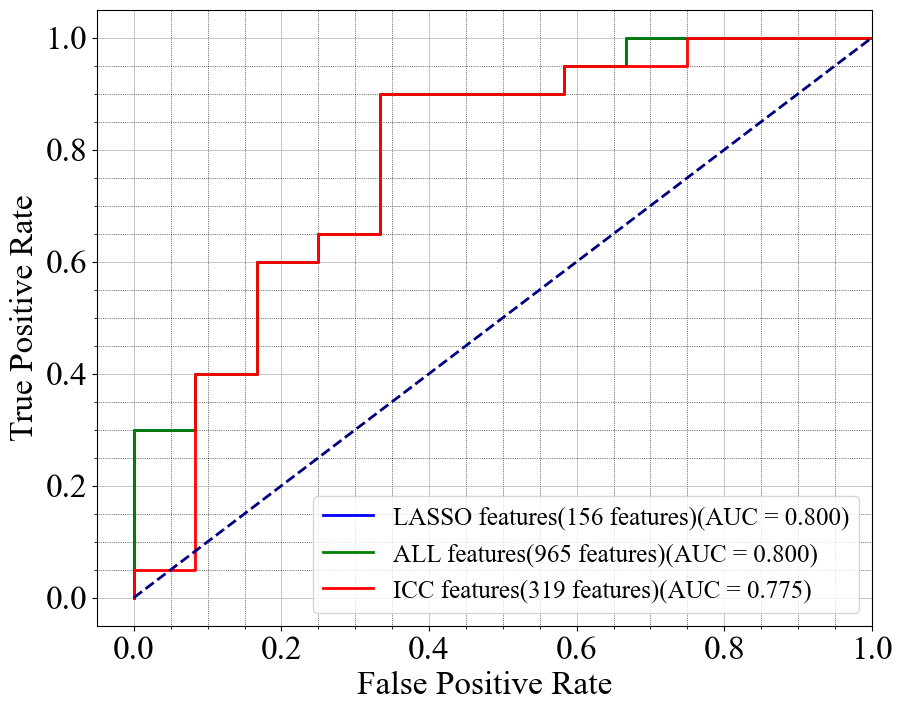

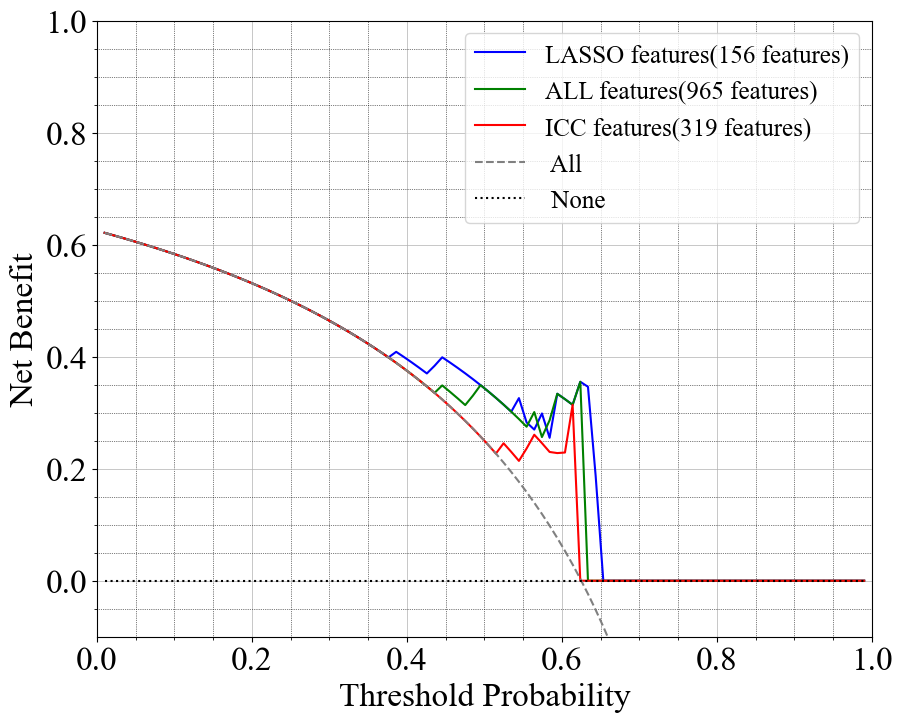

In [4]:
#svm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import numpy as np

# Function to calculate net benefit for the model
def calculate_net_benefit(thresholds, y_true, y_proba):
    net_benefits = []
    for threshold in thresholds:
        w = threshold / (1 - threshold)  # Weight for false positives
        predictions = y_proba >= threshold  # Predictions based on the current threshold
        tp = np.sum((predictions == 1) & (y_true == 1))  # True positives
        fp = np.sum((predictions == 1) & (y_true == 0))  # False positives
        net_benefit = tp - (fp * w)  # Calculate net benefit
        net_benefits.append(net_benefit / len(y_true))
    return net_benefits

# Calculate net benefit for "All" treated (assumes all cases are positive)
def net_benefit_all(thresholds, y_true):
    prevalence = np.mean(y_true)
    return [prevalence - (1 - prevalence) * (threshold / (1 - threshold)) for threshold in thresholds]

# Calculate net benefit for "None" treated (assumes no cases are positive)
def net_benefit_none(thresholds):
    return [0 for _ in thresholds]

# Decision Curve Analysis
def decision_curve_analysis(y_true, y_pred_proba, thresholds):
    num_cases = len(y_true)
    net_benefits = []
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        net_benefit = calculate_net_benefit(tp, fp, threshold, num_cases)
        net_benefits.append(net_benefit)
    return net_benefits

# Read datasets
train_data1 = pd.read_csv('D:/radiomic1/glioma/csv4/lasso_selected_features_train_t2_s1.csv')
test_data1 = pd.read_csv('D:/radiomic1/glioma/csv4/lasso_selected_features_test_t2_s1.csv')
train_data2 = pd.read_csv('D:/radiomic1/glioma/csv4/train_t2_s1.csv')
test_data2 = pd.read_csv('D:/radiomic1/glioma/csv4/test_t2_s1.csv')
train_data3 = pd.read_csv('D:/radiomic1/glioma/csv4/train_t2_s1_icc_selection.csv')
test_data3 = pd.read_csv('D:/radiomic1/glioma/csv4/test_t2_s1_icc_selection.csv')

# Prepare data for both models
X_train1 = train_data1.drop('label', axis=1)
y_train1 = train_data1['label']
X_test1 = test_data1.drop('label', axis=1)
y_test1 = test_data1['label']

X_train2 = train_data2.iloc[:, 2:] 
y_train2 = train_data2['label']
X_test2 = test_data2.iloc[:, 2:] 
y_test2 = test_data2['label']

X_train3 = train_data3.drop('label', axis=1)
y_train3 = train_data3['label']
X_test3 = test_data3.drop('label', axis=1)
y_test3 = test_data3['label']

# Initialize and train random forest models
model1 = SVC(kernel='rbf', C=1.0,probability=True)
model1.fit(X_train1, y_train1)
y_pred_proba1 = model1.predict_proba(X_test1)[:, 1]

model2 = SVC(kernel='rbf', C=1.0,probability=True)
model2.fit(X_train2, y_train2)
y_pred_proba2 = model2.predict_proba(X_test2)[:, 1]

model3 =SVC(kernel='rbf', C=1.0,probability=True)
model3.fit(X_train3, y_train3)
y_pred_proba3 = model3.predict_proba(X_test3)[:, 1]

# 计算AUC
auc_score1 = roc_auc_score(y_test1, y_pred_proba1)
auc_score2 = roc_auc_score(y_test2, y_pred_proba2)
auc_score3 = roc_auc_score(y_test3, y_pred_proba3)

# Range of thresholds from 0.01 to 0.99
thresholds = np.linspace(0.01, 0.99, 100)

# Calculate net benefits for both models
model1_net_benefits = calculate_net_benefit(thresholds, y_test1, y_pred_proba1)
all_net_benefits1 = net_benefit_all(thresholds, y_test1)
none_net_benefits1 = net_benefit_none(thresholds)

model2_net_benefits = calculate_net_benefit(thresholds, y_test2, y_pred_proba2)
all_net_benefits2 = net_benefit_all(thresholds, y_test2)
none_net_benefits2 = net_benefit_none(thresholds)

model3_net_benefits = calculate_net_benefit(thresholds, y_test3, y_pred_proba3)
all_net_benefits3 = net_benefit_all(thresholds, y_test3)
none_net_benefits3 = net_benefit_none(thresholds)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
plt.rcParams['font.family'] = 'Times New Roman'
# Assuming you have these variables defined: y_test1, y_pred_proba1, auc_score1, etc.

plt.figure(figsize=(10, 8))

# ROC Curve for Model 1
fpr1, tpr1, _ = roc_curve(y_test1, y_pred_proba1)
plt.plot(fpr1, tpr1, color='blue', lw=2, label='LASSO features(156 features)(AUC = %0.3f)' % auc_score1)

# ROC Curve for Model 2
fpr2, tpr2, _ = roc_curve(y_test2, y_pred_proba2)
plt.plot(fpr2, tpr2, color='green', lw=2, label='ALL features(965 features)(AUC = %0.3f)' % auc_score2)

fpr3, tpr3, _ = roc_curve(y_test3, y_pred_proba3)
plt.plot(fpr3, tpr3, color='red', lw=2, label='ICC features(319 features)(AUC = %0.3f)' % auc_score3)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc="lower right", fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black') 
plt.show()

plt.figure(figsize=(10, 8))
# DCA for Model 1
plt.plot(thresholds, model1_net_benefits, label='LASSO features(156 features)', color='blue', linestyle='-')

# DCA for Model 2
plt.plot(thresholds, model2_net_benefits, label='ALL features(965 features)', color='green', linestyle='-')
# DCA for Model 3
plt.plot(thresholds, model3_net_benefits, label='ICC features(319 features)', color='red', linestyle='-')
plt.plot(thresholds, all_net_benefits1, label=' All', color='gray', linestyle='--')
plt.plot(thresholds, none_net_benefits1, label=' None', color='black', linestyle=':')
plt.xlabel('Threshold Probability', fontsize=24)
plt.ylabel('Net Benefit', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper right', fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black') 
plt.xlim([0, 1])
plt.ylim([-0.1, 1])
plt.show()